In [12]:
import os, yaml, time
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import torch
from src.data_utils import *
from src.denoising_utils import *
from src.unet_model import Unet3D
from src.residuals_nematic import ResidualsNematic
import pathlib
from tqdm import tqdm
import numpy as np
from findiff import Diff


mpl.rcParams.update({'lines.linewidth': 2, 'lines.markersize': 15})
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = False
mpl.rcParams['figure.facecolor'] = 'black'


In [13]:
# Specify the path to your directory containing the model folders 
# directory_path = pathlib.Path('D:\\diffusion model\\TEST4\\denoising-diffusion-flax-20250107T081638Z-001\\train result\\PIDM-Nematics-V1-model\\trained_models\\run_1')
directory_path = pathlib.Path('D:\\diffusion model\\TEST4\\denoising-diffusion-flax-20250107T081638Z-001\\PIDM-Nematics-V3-inclusion\\trained_models\\run_cond_inclusion')
name = 'model'
load_model_step = 5000

os.chdir(directory_path)
os.getcwd()

'D:\\diffusion model\\TEST4\\denoising-diffusion-flax-20250107T081638Z-001\\PIDM-Nematics-V3-inclusion\\trained_models\\run_cond_inclusion'

In [14]:


no_samples = 1 # number of samples to generate
create_gif = True # create GIFs of denoising process for visualization (may take some time)
# test_batches = -1 # set to -1 for full evaluation of both test sets

load_path = os.path.join(directory_path)
config = yaml.safe_load(Path(load_path, 'model', 'model.yaml').read_text())

In [52]:
# diffusion parameters
if config['x0_estimation'] == 'mean':
    use_ddim_x0 = False
elif config['x0_estimation'] == 'sample':
    use_ddim_x0 = True
ddim_steps = config['ddim_steps']
residual_grad_guidance = config['residual_grad_guidance'] 


# diffusion model params
gov_eqs = config['gov_eqs']
if gov_eqs != 'Nematic' and residual_grad_guidance:
    raise ValueError('Gradient guidance only implemented for Darcy equation.')
fd_acc = config['fd_acc']
diff_steps = config['diff_steps']
use_dynamic_threshold = False
self_condition = False
use_double = False

save_output = True
eval_residuals = True

data_paths = None
if gov_eqs == 'Nematic':
    input_dim = 2
    output_dim = 2
    pixels_at_boundary = True
    domain_length = 1.
    reverse_d1 = False
    bcs = 'none' # 'none', 'periodic'
    pixels_per_dim = 64
    train_batch_size = 32
    if name == 'local_test':
        no_samples = 1
        train_batch_size = 8
    sigmoid_last_channel = False
else:
    raise ValueError('Unknown governing equations.')
    
output_save_dir = load_path + '/evaluation'
# check if output dir exists, if yes iterate name, e.g. evaluation_1, evaluation_2, ...
if os.path.exists(output_save_dir):
    i = 1
    while os.path.exists(output_save_dir + f'_{i}/'):
        i += 1
    output_save_dir += f'_{i}/'
os.makedirs(output_save_dir, exist_ok=True)

if use_double:
    torch.set_default_dtype(torch.float64)

In [17]:

diffusion_utils = DenoisingDiffusion(diff_steps, device, residual_grad_guidance)

if gov_eqs == 'Nematic':
    model = Unet3D(dim = 32, channels = output_dim, sigmoid_last_channel = sigmoid_last_channel).to(device)

load_model(Path(load_path, 'model', 'checkpoint_' + str(load_model_step) + '.pt'), model)

if gov_eqs == 'Nematic':
    residuals = ResidualsNematic(model = model, fd_acc = fd_acc, pixels_per_dim = pixels_per_dim, pixels_at_boundary = pixels_at_boundary, reverse_d1 = None, device = device, bcs = bcs, domain_length =1, residual_grad_guidance = residual_grad_guidance, use_ddim_x0 = use_ddim_x0, ddim_steps = ddim_steps)
else:
    raise ValueError('Unknown residuals mode.')

# count number of trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {num_params}')

# generate sample based on validation set
if gov_eqs == 'Nematic':
    conditioning_input = None
    sample_shape = (no_samples, output_dim, pixels_per_dim, pixels_per_dim)


Checkpoint loaded from D:\diffusion model\TEST4\denoising-diffusion-flax-20250107T081638Z-001\PIDM-Nematics-V3-inclusion\trained_models\run_cond_inclusion\model\checkpoint_5000.pt
Number of trainable parameters: 10386482


Using model to generate Q tensor field

In [6]:
N1 = 64
N2 = 64
# make this as for loop
icx_list = []
icy_list = []
R_list = []
anchoring_type_list = []
inclusion_list = []
anchoring_direction_list = []
Mask_input = torch.zeros((no_samples, 2, N1, N2))
for i in range(no_samples):
    icx = N1/2 + np.random.randint(-10, 10)
    icy = N2/2 + np.random.randint(-10, 10)
    R = np.random.randint(6, 15)
    # anchoring_type = np.random.randint(1, 5)
    anchoring_type = i+1
    # inclusion = np.random.choice([True, False])
    inclusion = True
    anchoring_direction = 2*np.pi*np.random.rand()
    mask = diffusion_utils.generate_mask(N1, N2, icx, icy, R, anchoring_type, inclusion, anchoring_direction)
    # plt.figure()
    # plt.imshow(mask[:,:,1], cmap='gray')
    # print(mask[:,:,1])
    # print((np.squeeze(mask[0,:,:]).shape))
    # print(mask[1,:,:])
    # plt.figure(figsize=(10, 10))
    print(f'icx: {icx}, icy: {icy}, R: {R}, anchoring_type: {anchoring_type}, inclusion: {inclusion}, anchoring_direction: {anchoring_direction}')
    # plt.imshow((mask[1,:,:]), cmap='gray')
    icx_list.append(icx)
    icy_list.append(icy)
    R_list.append(R)
    anchoring_type_list.append(anchoring_type)
    inclusion_list.append(inclusion)
    anchoring_direction_list.append(anchoring_direction)
    Mask_input[i] = torch.tensor(mask)  # 显式指定设备
print(Mask_input.shape)


icx: 37.0, icy: 38.0, R: 13, anchoring_type: 1, inclusion: True, anchoring_direction: 4.950765204280567
icx: 38.0, icy: 23.0, R: 14, anchoring_type: 2, inclusion: True, anchoring_direction: 5.883631976658391
icx: 40.0, icy: 34.0, R: 12, anchoring_type: 3, inclusion: True, anchoring_direction: 1.583789055185993
icx: 32.0, icy: 26.0, R: 13, anchoring_type: 4, inclusion: True, anchoring_direction: 3.833081111776448
torch.Size([4, 2, 64, 64])


In [53]:
N1 = 64
N2 = 64
Mask_input = torch.zeros((no_samples, 2, N1, N2))
for i in range(no_samples):
    # mask = diffusion_utils.generate_mask(N1, N2, 32, 32, 13, 1, True, 0)
    mask = diffusion_utils.generate_mask_triangle(15, 15, 50, 15, 30, 45, N1, N2, True, 4)
    # mask = diffusion_utils.generate_mask_triangle(15, 15, 45, 45, 20, 45, N1, N2, True, i+1)
    # mask = diffusion_utils.generate_mask_pentagon(25, 15, 40, 15, 50, 30, 32, 45, 15, 30, N1, N2, True, i+1)
    Mask_input[i] = torch.tensor(mask)
print(Mask_input.shape)

torch.Size([1, 2, 64, 64])


In [54]:
output = diffusion_utils.p_sample_loop(conditioning_input, Mask_input, sample_shape, 
                        save_output=save_output, surpress_noise=True, 
                        use_dynamic_threshold=use_dynamic_threshold, 
                        residual_func=residuals, eval_residuals = eval_residuals)


Save figure

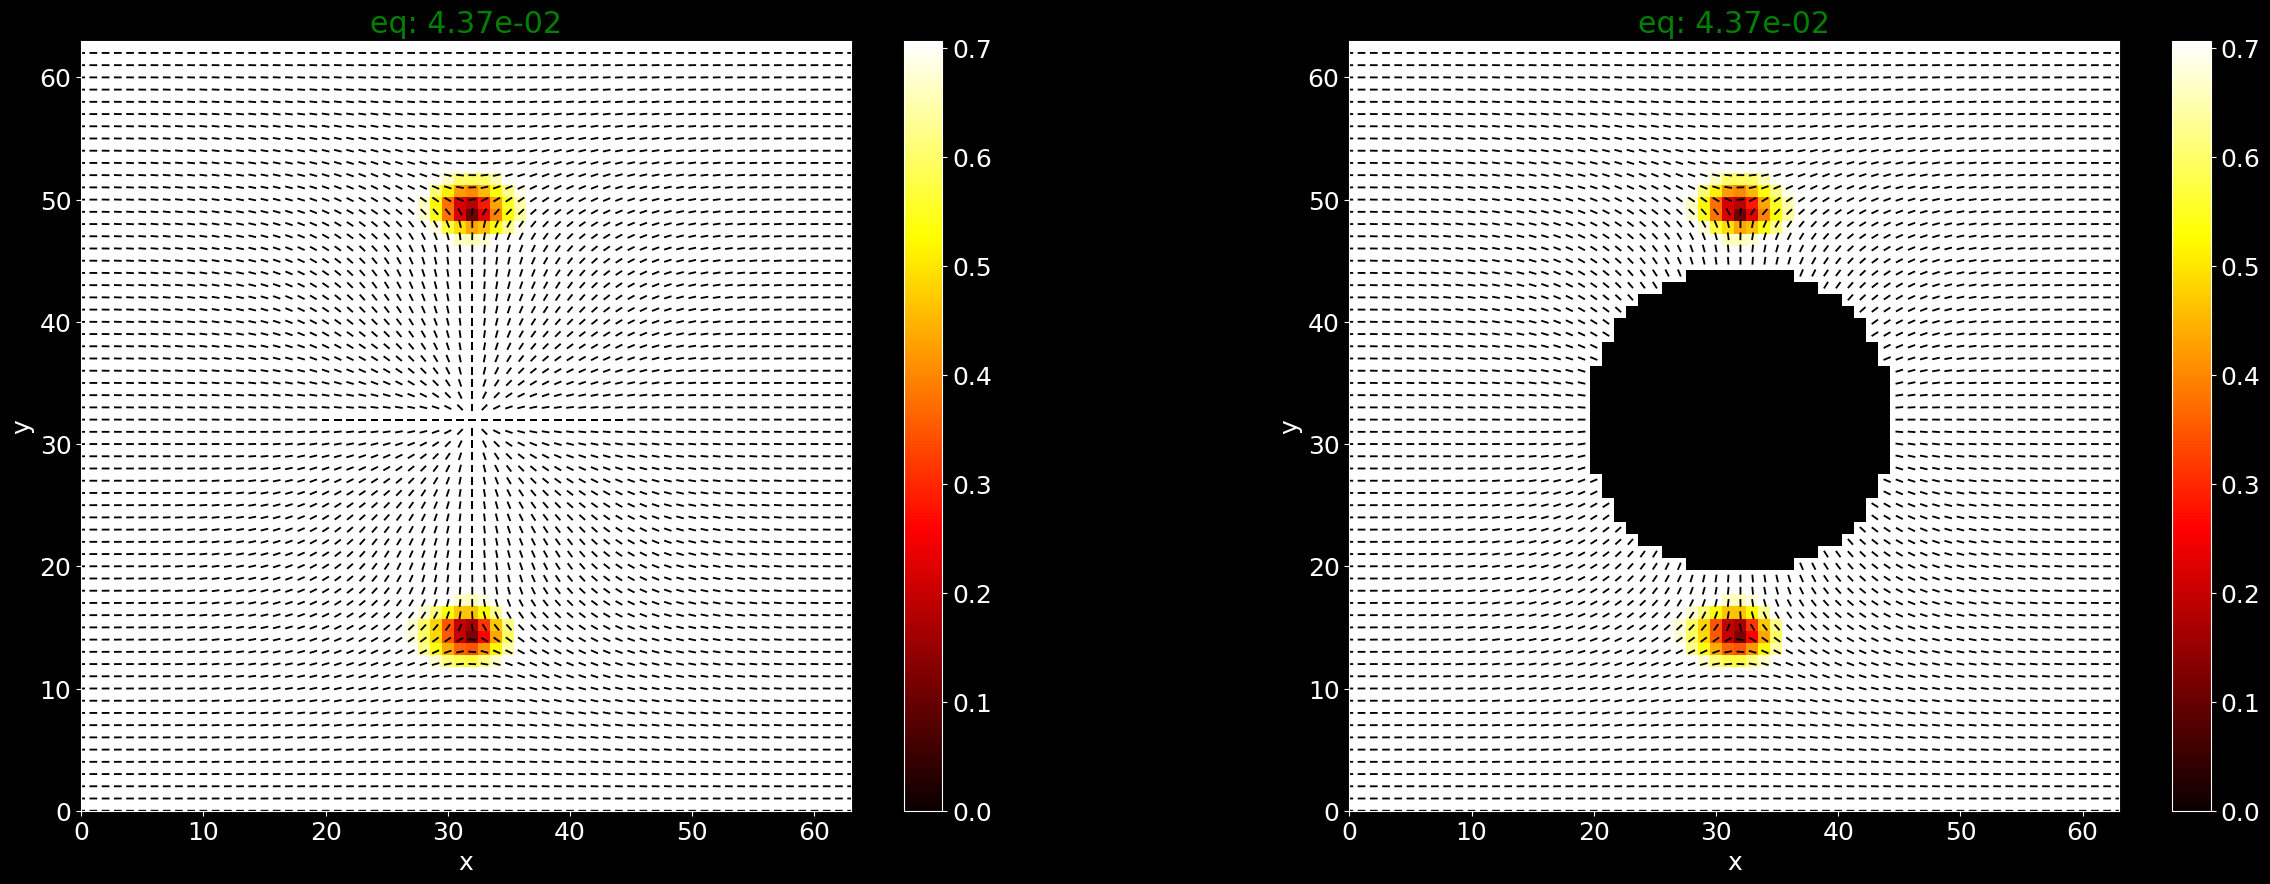

100%|██████████| 101/101 [00:27<00:00,  3.66it/s]
C:\Users\52577\AppData\Local\Temp\ipykernel_26792\3602615638.py:137: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(output_save_dir_validation+'/gif/'+ str(sel_sample) + '_sample_' + str(i)  + '.png'))


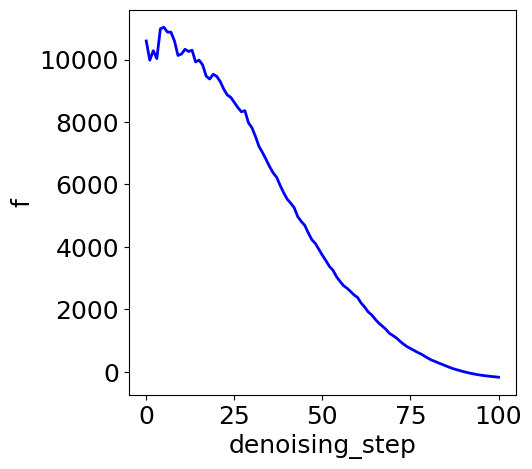

In [20]:
if eval_residuals:
    seqs = output[0]
    residual = output[1]['residual']
    residual = residual.abs().mean(dim=tuple(range(1, residual.ndim))) # reduce to batch dim
else:
    seqs = output
    
output_save_dir_validation = output_save_dir + f'/validation/step_{load_model_step}/'
os.makedirs(output_save_dir_validation, exist_ok=True)


for seq_idx, seq in enumerate(seqs):

    # NOTE: We here only evaluate the sample at the final timestep and skip model_output as this is identical (since no noise is applied in last step).
    if seq_idx == 1:
        continue

    # remove frame dimension
    seq = torch.stack(seq, dim=0)
    if len(seq.shape) == 6:
        seq = seq.squeeze(-3)
        
    last_preds = seq[-1].numpy()
    sel_samples = np.arange(no_samples)
    channels = np.arange(output_dim)

    for sel_sample in sel_samples:
        last_pred = last_preds[sel_sample, :]
        last_pred_temp = rearrange(last_pred, 'c h w -> h w c')
        Qxx = last_pred_temp[:,:,0]
        Qxy = last_pred_temp[:,:,1]
        Azi = Mask_input[sel_sample,0,:,:]
        Seq = np.sqrt(2)/2
        Azi_Qxx = Seq * np.cos(2*Azi)
        Azi_Qxy = Seq * np.sin(2*Azi)
        Qxx = np.where(Mask_input[sel_sample,1,:,:] == 0, Azi_Qxx, Qxx)
        Qxy = np.where(Mask_input[sel_sample,1,:,:] == 0, Azi_Qxy, Qxy)
        N2, N1 = Qxx.shape
        nx = np.zeros((N2,N1))
        ny = np.zeros((N2,N1))
        S = np.zeros((N2,N1))
        x, y = np.meshgrid(np.arange(0, N1, 1), np.arange(0, N2, 1))
        for i in range(N2):
            for j in range(N1):
                matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                                [Qxy[i, j], -Qxx[i, j]]])
                vals, vecs = np.linalg.eigh(matrix)
                index = np.argmax(vals)
                nx[i,j] = vecs[0, index]
                ny[i,j] = vecs[1, index]
                S[i,j] = vals[index]*2
        # plt.figure(figsize=(10, 10))
        # S = np.where(Mask_input[sel_sample,1,:,:] != 0, S, np.nan)
        # nx = np.where(Mask_input[sel_sample,1,:,:] != 0, nx, np.nan)
        # ny = np.where(Mask_input[sel_sample,1,:,:] != 0, ny, np.nan)
        fig= plt.figure(figsize=(30, 10))
        ax = fig.add_subplot(1,2,1)
        im = ax.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
        plt.colorbar(im)
        plt.xlabel('x')
        plt.ylabel('y')
        ax.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
        if eval_residuals:
            title = f'eq: {residual[sel_sample]:.2e}'
            plt.title(title, color='green')
        filename = 'sample_' + str(sel_sample)  + '.png'
        S = np.where(Mask_input[sel_sample,1,:,:] != 0, S, np.nan)
        nx = np.where(Mask_input[sel_sample,1,:,:] != 0, nx, np.nan)
        ny = np.where(Mask_input[sel_sample,1,:,:] != 0, ny, np.nan)
        ax2 = fig.add_subplot(1,2,2)
        im = ax2.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
        plt.colorbar(im)
        plt.xlabel('x')
        plt.ylabel('y')
        ax2.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
        if eval_residuals:
            title = f'eq: {residual[sel_sample]:.2e}'
            plt.title(title, color='green')
        filename = 'sample_' + str(sel_sample)  + '.png'
        plt.savefig(output_save_dir_validation + filename, bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close(fig)
        os.makedirs(output_save_dir_validation + f'/sample_{sel_sample}/', exist_ok=True)
        for sel_channel in channels:
            np.savetxt(output_save_dir_validation + f'/sample_{sel_sample}/' + '_' + str(sel_channel) + '.csv', last_pred[sel_channel], delimiter=',')

        # create_gif = False
        if create_gif:
            f=[]
            os.makedirs(output_save_dir_validation + '/gif/', exist_ok=True)
            Q = rearrange(seq[:,sel_sample,:,:], 't c h w -> t h w c')
            Q.detach().cpu().numpy()
            Q = Q.numpy()
            for frame_t in tqdm(range(0,Q.shape[0],10)):
                Qxx = Q[frame_t,:,:,0]
                Qxy = Q[frame_t,:,:,1]
                d_dx = Diff(1, 1,acc=2)
                d_dy = Diff(0, 1,acc=2)
                laplacian = d_dx**2+d_dy**2
                dxdQxx = d_dx(Qxx)
                dydQxx = d_dy(Qxx)
                dxdQxy = d_dx(Qxy)
                dydQxy = d_dy(Qxy)
                f1 = -0.25 * (Qxx**2 + Qxy**2) + 0.25 * (Qxx**2 + Qxy**2)**2 + 0.5 * (dxdQxx**2 + dydQxx**2 + dxdQxy**2 + dydQxy**2)
                f1 = np.where(Mask_input[sel_sample,1,:,:] != 0, f1, 0)
                f.append(np.sum(f1, axis=(0,1)))
                N2, N1 = Qxx.shape[1], Qxx.shape[0]
                nx = np.zeros((N2,N1))
                ny = np.zeros((N2,N1))
                S = np.zeros((N2,N1))
                x, y = np.meshgrid(np.arange(0, N1, 1), np.arange(0, N2, 1))
                for i in range(N2):
                    for j in range(N1):
                        matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                                        [Qxy[i, j], -Qxx[i, j]]])
                        vals, vecs = np.linalg.eigh(matrix)
                        index = np.argmax(vals)
                        nx[i,j] = vecs[0, index]
                        ny[i,j] = vecs[1, index]
                        S[i,j] = vals[index]*2
                S = np.where(Mask_input[sel_sample,1,:,:] != 0, S, np.nan)
                nx = np.where(Mask_input[sel_sample,1,:,:] != 0, nx, np.nan)
                ny = np.where(Mask_input[sel_sample,1,:,:] != 0, ny, np.nan)
                fig, ax = plt.subplots(figsize=(10, 10))
                im = ax.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
                plt.colorbar(im)
                plt.xlabel('x')
                plt.ylabel('y')
                ax.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
                plt.title('t = ' + str(frame_t), color='green')
                filename = str(sel_sample)+'_sample_' + str(frame_t)  + '.png'
                plt.savefig(output_save_dir_validation+'/gif/' + filename, bbox_inches='tight', pad_inches=0)
                plt.close(fig)
            # load this image to create gif
            images = []
            for i in range(0,Q.shape[0],10):
                images.append(imageio.imread(output_save_dir_validation+'/gif/'+ str(sel_sample) + '_sample_' + str(i)  + '.png'))
            imageio.mimsave(output_save_dir_validation+'/gif/' + '_sample_' + str(sel_sample)  + '.gif', images)
            fig, ax = plt.subplots(figsize=(5, 5))
            fig.set_facecolor('white')
            ax.set_facecolor('white')
            ax.tick_params(colors='black')
            ax.spines['top'].set_color('black')
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.spines['right'].set_color('black')
            ax.plot(f, color='blue',lw=2)
            plt.xlabel('denoising_step',color='black')
            plt.ylabel('f',color='black')
            filename = 'sample_free_energy_' + str(sel_sample)  + '.png'
            plt.savefig(output_save_dir_validation + filename, bbox_inches='tight', pad_inches=0.2)
            plt.show()
            plt.close(fig)
            np.savetxt(output_save_dir_validation + f'/sample_{sel_sample}/' + str(sel_channel) + '_free_energy.csv', f, delimiter=',')



if eval_residuals:
    residuals_array = residual.detach().cpu().numpy()

    df_data = {'Sample Index': list(range(no_samples)),
            'Residuals (abs)': list(residuals_array)}
        
    df = pd.DataFrame(df_data)
    csv_path = os.path.join(output_save_dir_validation, 'sample_statistics.csv')
    df.to_csv(csv_path, index=False)



(4096, 2)


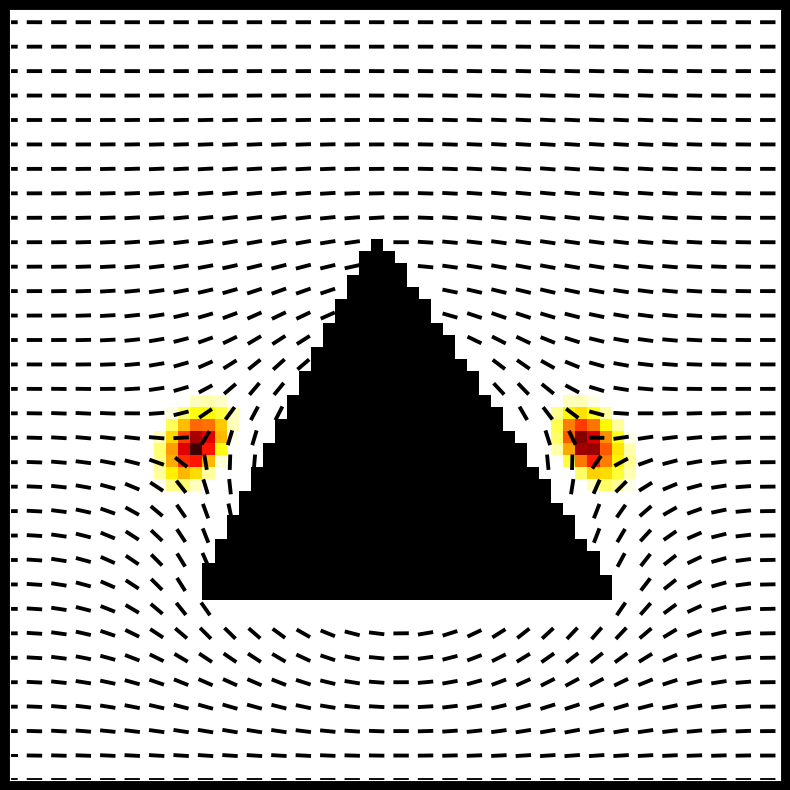

  0%|          | 0/101 [00:00<?, ?it/s]

(4096, 2)


  1%|          | 1/101 [00:00<00:58,  1.72it/s]

(4096, 2)


  2%|▏         | 2/101 [00:01<00:56,  1.76it/s]

(4096, 2)


  3%|▎         | 3/101 [00:01<00:58,  1.69it/s]

(4096, 2)


  4%|▍         | 4/101 [00:02<00:59,  1.64it/s]

(4096, 2)


  5%|▍         | 5/101 [00:03<01:00,  1.58it/s]

(4096, 2)


  6%|▌         | 6/101 [00:03<00:59,  1.58it/s]

(4096, 2)


  7%|▋         | 7/101 [00:04<00:58,  1.59it/s]

(4096, 2)


  8%|▊         | 8/101 [00:04<00:59,  1.56it/s]

(4096, 2)


  9%|▉         | 9/101 [00:05<00:58,  1.58it/s]

(4096, 2)


 10%|▉         | 10/101 [00:06<00:57,  1.59it/s]

(4096, 2)


 11%|█         | 11/101 [00:06<00:57,  1.57it/s]

(4096, 2)


 12%|█▏        | 12/101 [00:07<00:56,  1.57it/s]

(4096, 2)


 13%|█▎        | 13/101 [00:08<00:56,  1.56it/s]

(4096, 2)


 14%|█▍        | 14/101 [00:08<00:55,  1.56it/s]

(4096, 2)


 15%|█▍        | 15/101 [00:09<00:54,  1.58it/s]

(4096, 2)


 16%|█▌        | 16/101 [00:10<00:55,  1.52it/s]

(4096, 2)


 17%|█▋        | 17/101 [00:10<00:55,  1.50it/s]

(4096, 2)


 18%|█▊        | 18/101 [00:11<00:53,  1.54it/s]

(4096, 2)


 19%|█▉        | 19/101 [00:12<00:52,  1.56it/s]

(4096, 2)


 20%|█▉        | 20/101 [00:12<00:51,  1.56it/s]

(4096, 2)


 21%|██        | 21/101 [00:13<01:03,  1.27it/s]

(4096, 2)


 22%|██▏       | 22/101 [00:14<00:58,  1.36it/s]

(4096, 2)


 23%|██▎       | 23/101 [00:15<00:54,  1.44it/s]

(4096, 2)


 24%|██▍       | 24/101 [00:15<00:51,  1.49it/s]

(4096, 2)


 25%|██▍       | 25/101 [00:16<00:49,  1.53it/s]

(4096, 2)


 26%|██▌       | 26/101 [00:16<00:47,  1.57it/s]

(4096, 2)


 27%|██▋       | 27/101 [00:17<00:46,  1.59it/s]

(4096, 2)


 28%|██▊       | 28/101 [00:18<00:45,  1.61it/s]

(4096, 2)


 29%|██▊       | 29/101 [00:18<00:45,  1.59it/s]

(4096, 2)


 30%|██▉       | 30/101 [00:19<00:44,  1.61it/s]

(4096, 2)


 31%|███       | 31/101 [00:19<00:43,  1.61it/s]

(4096, 2)


 32%|███▏      | 32/101 [00:20<00:42,  1.62it/s]

(4096, 2)


 33%|███▎      | 33/101 [00:21<00:41,  1.63it/s]

(4096, 2)


 34%|███▎      | 34/101 [00:21<00:40,  1.64it/s]

(4096, 2)


 35%|███▍      | 35/101 [00:22<00:40,  1.64it/s]

(4096, 2)


 36%|███▌      | 36/101 [00:22<00:39,  1.63it/s]

(4096, 2)


 37%|███▋      | 37/101 [00:23<00:40,  1.59it/s]

(4096, 2)


 38%|███▊      | 38/101 [00:24<00:39,  1.61it/s]

(4096, 2)


 39%|███▊      | 39/101 [00:24<00:39,  1.57it/s]

(4096, 2)


 40%|███▉      | 40/101 [00:25<00:39,  1.56it/s]

(4096, 2)


 41%|████      | 41/101 [00:26<00:38,  1.55it/s]

(4096, 2)


 42%|████▏     | 42/101 [00:26<00:37,  1.56it/s]

(4096, 2)


 43%|████▎     | 43/101 [00:27<00:37,  1.57it/s]

(4096, 2)


 44%|████▎     | 44/101 [00:28<00:36,  1.54it/s]

(4096, 2)


 45%|████▍     | 45/101 [00:28<00:35,  1.58it/s]

(4096, 2)


 46%|████▌     | 46/101 [00:29<00:34,  1.60it/s]

(4096, 2)


 47%|████▋     | 47/101 [00:29<00:33,  1.62it/s]

(4096, 2)


 48%|████▊     | 48/101 [00:30<00:32,  1.63it/s]

(4096, 2)


 49%|████▊     | 49/101 [00:31<00:31,  1.64it/s]

(4096, 2)


 50%|████▉     | 50/101 [00:31<00:31,  1.63it/s]

(4096, 2)


 50%|█████     | 51/101 [00:32<00:30,  1.65it/s]

(4096, 2)


 51%|█████▏    | 52/101 [00:33<00:29,  1.65it/s]

(4096, 2)


 52%|█████▏    | 53/101 [00:33<00:29,  1.64it/s]

(4096, 2)


 53%|█████▎    | 54/101 [00:34<00:28,  1.63it/s]

(4096, 2)


 54%|█████▍    | 55/101 [00:34<00:28,  1.62it/s]

(4096, 2)


 55%|█████▌    | 56/101 [00:35<00:27,  1.64it/s]

(4096, 2)


 56%|█████▋    | 57/101 [00:36<00:26,  1.66it/s]

(4096, 2)


 57%|█████▋    | 58/101 [00:36<00:26,  1.65it/s]

(4096, 2)


 58%|█████▊    | 59/101 [00:37<00:25,  1.65it/s]

(4096, 2)


 59%|█████▉    | 60/101 [00:37<00:24,  1.66it/s]

(4096, 2)


 60%|██████    | 61/101 [00:38<00:27,  1.48it/s]

(4096, 2)


 61%|██████▏   | 62/101 [00:39<00:25,  1.51it/s]

(4096, 2)


 62%|██████▏   | 63/101 [00:39<00:24,  1.55it/s]

(4096, 2)


 63%|██████▎   | 64/101 [00:40<00:23,  1.58it/s]

(4096, 2)


 64%|██████▍   | 65/101 [00:41<00:22,  1.59it/s]

(4096, 2)


 65%|██████▌   | 66/101 [00:41<00:21,  1.60it/s]

(4096, 2)


 66%|██████▋   | 67/101 [00:42<00:21,  1.61it/s]

(4096, 2)


 67%|██████▋   | 68/101 [00:43<00:20,  1.63it/s]

(4096, 2)


 68%|██████▊   | 69/101 [00:43<00:19,  1.64it/s]

(4096, 2)


 69%|██████▉   | 70/101 [00:44<00:19,  1.62it/s]

(4096, 2)


 70%|███████   | 71/101 [00:44<00:18,  1.64it/s]

(4096, 2)


 71%|███████▏  | 72/101 [00:45<00:17,  1.64it/s]

(4096, 2)


 72%|███████▏  | 73/101 [00:46<00:16,  1.65it/s]

(4096, 2)


 73%|███████▎  | 74/101 [00:46<00:16,  1.65it/s]

(4096, 2)


 74%|███████▍  | 75/101 [00:47<00:15,  1.66it/s]

(4096, 2)


 75%|███████▌  | 76/101 [00:47<00:14,  1.67it/s]

(4096, 2)


 76%|███████▌  | 77/101 [00:48<00:14,  1.67it/s]

(4096, 2)


 77%|███████▋  | 78/101 [00:49<00:13,  1.67it/s]

(4096, 2)


 78%|███████▊  | 79/101 [00:49<00:13,  1.66it/s]

(4096, 2)


 79%|███████▉  | 80/101 [00:50<00:12,  1.65it/s]

(4096, 2)


 80%|████████  | 81/101 [00:50<00:12,  1.66it/s]

(4096, 2)


 81%|████████  | 82/101 [00:51<00:11,  1.67it/s]

(4096, 2)


 82%|████████▏ | 83/101 [00:52<00:10,  1.67it/s]

(4096, 2)


 83%|████████▎ | 84/101 [00:52<00:10,  1.67it/s]

(4096, 2)


 84%|████████▍ | 85/101 [00:53<00:09,  1.67it/s]

(4096, 2)


 85%|████████▌ | 86/101 [00:53<00:09,  1.66it/s]

(4096, 2)


 86%|████████▌ | 87/101 [00:54<00:08,  1.66it/s]

(4096, 2)


 87%|████████▋ | 88/101 [00:55<00:07,  1.66it/s]

(4096, 2)


 88%|████████▊ | 89/101 [00:55<00:07,  1.66it/s]

(4096, 2)


 89%|████████▉ | 90/101 [00:56<00:06,  1.66it/s]

(4096, 2)


 90%|█████████ | 91/101 [00:56<00:06,  1.65it/s]

(4096, 2)


 91%|█████████ | 92/101 [00:57<00:05,  1.66it/s]

(4096, 2)


 92%|█████████▏| 93/101 [00:58<00:04,  1.67it/s]

(4096, 2)


 93%|█████████▎| 94/101 [00:58<00:04,  1.68it/s]

(4096, 2)


 94%|█████████▍| 95/101 [00:59<00:03,  1.68it/s]

(4096, 2)


 95%|█████████▌| 96/101 [00:59<00:02,  1.68it/s]

(4096, 2)


 96%|█████████▌| 97/101 [01:00<00:02,  1.68it/s]

(4096, 2)


 97%|█████████▋| 98/101 [01:01<00:01,  1.69it/s]

(4096, 2)


 98%|█████████▊| 99/101 [01:01<00:01,  1.69it/s]

(4096, 2)


 99%|█████████▉| 100/101 [01:02<00:00,  1.69it/s]

(4096, 2)


100%|██████████| 101/101 [01:02<00:00,  1.61it/s]
C:\Users\52577\AppData\Local\Temp\ipykernel_26792\1385212084.py:137: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(output_save_dir_validation+'/gif/'+ str(sel_sample) + '_sample_' + str(i)  + '.png'))


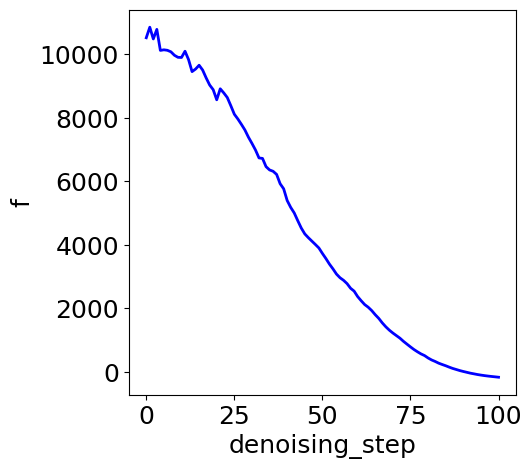

In [55]:
if eval_residuals:
    seqs = output[0]
    residual = output[1]['residual']
    residual = residual.abs().mean(dim=tuple(range(1, residual.ndim))) # reduce to batch dim
else:
    seqs = output
    
output_save_dir_validation = output_save_dir + f'/validation/step_{load_model_step}/'
os.makedirs(output_save_dir_validation, exist_ok=True)

from scipy.interpolate import griddata

for seq_idx, seq in enumerate(seqs):

    # NOTE: We here only evaluate the sample at the final timestep and skip model_output as this is identical (since no noise is applied in last step).
    if seq_idx == 1:
        continue

    # remove frame dimension
    seq = torch.stack(seq, dim=0)
    if len(seq.shape) == 6:
        seq = seq.squeeze(-3)
        
    last_preds = seq[-1].numpy()
    sel_samples = np.arange(no_samples)
    channels = np.arange(output_dim)

    for sel_sample in sel_samples:
        last_pred = last_preds[sel_sample, :]
        last_pred_temp = rearrange(last_pred, 'c h w -> h w c')
        Qxx = last_pred_temp[:,:,0]
        Qxy = last_pred_temp[:,:,1]
        Azi = Mask_input[sel_sample,0,:,:]
        Seq = np.sqrt(2)/2
        Azi_Qxx = Seq * np.cos(2*Azi)
        Azi_Qxy = Seq * np.sin(2*Azi)
        Qxx = np.where(Mask_input[sel_sample,1,:,:] == 0, Azi_Qxx, Qxx)
        Qxy = np.where(Mask_input[sel_sample,1,:,:] == 0, Azi_Qxy, Qxy)
        N2, N1 = Qxx.shape
        nx = np.zeros((N2,N1))
        ny = np.zeros((N2,N1))
        S = np.zeros((N2,N1))
        x, y = np.meshgrid(np.arange(0, N1, 1), np.arange(0, N2, 1))
        for i in range(N2):
            for j in range(N1):
                matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                                [Qxy[i, j], -Qxx[i, j]]])
                vals, vecs = np.linalg.eigh(matrix)
                index = np.argmax(vals)
                nx[i,j] = vecs[0, index]
                ny[i,j] = vecs[1, index]
                S[i,j] = vals[index]*2
        filename = 'sample_' + str(sel_sample)  + '.png'
        S = np.where(Mask_input[sel_sample,1,:,:] != 0, S, np.nan)
        nx = np.where(Mask_input[sel_sample,1,:,:] != 0, nx, np.nan)
        ny = np.where(Mask_input[sel_sample,1,:,:] != 0, ny, np.nan)
                # interpolate to make the data point more sparse
        x, y = np.meshgrid(np.arange(0, N1, 1), np.arange(0, N2, 1))
        xi, yi = np.meshgrid(np.arange(0, N1, 2), np.arange(0, N2, 2))
        points = np.array([x.flatten(), y.flatten()]).T
        print(points.shape)
        # interpolate S, nx, ny to xi, yi
        Si = griddata(points, S.flatten(), (xi, yi))
        nxi = griddata(points, nx.flatten(), (xi, yi))
        nyi = griddata(points, ny.flatten(), (xi, yi))
        fig, ax2 = plt.subplots(figsize=(10, 10))
        im = ax2.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
        # plt.colorbar(im)
        ax2.quiver(xi, yi, nxi, nyi, color='black', scale=50, headlength=0, headaxislength=0, headwidth=0, width=0.005, pivot='middle')
        ax2.set_xticks([])
        ax2.set_yticks([])
        filename = 'sample_' + str(sel_sample)  + '.png'
        plt.savefig(output_save_dir_validation + filename, bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close(fig)
        os.makedirs(output_save_dir_validation + f'/sample_{sel_sample}/', exist_ok=True)
        for sel_channel in channels:
            np.savetxt(output_save_dir_validation + f'/sample_{sel_sample}/' + '_' + str(sel_channel) + '.csv', last_pred[sel_channel], delimiter=',')

        # create_gif = False
        if create_gif==False:
            f=[]
            os.makedirs(output_save_dir_validation + '/gif/', exist_ok=True)
            Q = rearrange(seq[:,sel_sample,:,:], 't c h w -> t h w c')
            Q.detach().cpu().numpy()
            Q = Q.numpy()
            for frame_t in tqdm(range(0,Q.shape[0],10)):
                Qxx = Q[frame_t,:,:,0]
                Qxy = Q[frame_t,:,:,1]
                d_dx = Diff(1, 1,acc=2)
                d_dy = Diff(0, 1,acc=2)
                laplacian = d_dx**2+d_dy**2
                dxdQxx = d_dx(Qxx)
                dydQxx = d_dy(Qxx)
                dxdQxy = d_dx(Qxy)
                dydQxy = d_dy(Qxy)
                f1 = -0.25 * (Qxx**2 + Qxy**2) + 0.25 * (Qxx**2 + Qxy**2)**2 + 0.5 * (dxdQxx**2 + dydQxx**2 + dxdQxy**2 + dydQxy**2)
                f1 = np.where(Mask_input[sel_sample,1,:,:] != 0, f1, 0)
                f.append(np.sum(f1, axis=(0,1)))
                N2, N1 = Qxx.shape[1], Qxx.shape[0]
                nx = np.zeros((N2,N1))
                ny = np.zeros((N2,N1))
                S = np.zeros((N2,N1))
                x, y = np.meshgrid(np.arange(0, N1, 1), np.arange(0, N2, 1))
                for i in range(N2):
                    for j in range(N1):
                        matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                                        [Qxy[i, j], -Qxx[i, j]]])
                        vals, vecs = np.linalg.eigh(matrix)
                        index = np.argmax(vals)
                        nx[i,j] = vecs[0, index]
                        ny[i,j] = vecs[1, index]
                        S[i,j] = vals[index]*2
                S = np.where(Mask_input[sel_sample,1,:,:] != 0, S, np.nan)
                nx = np.where(Mask_input[sel_sample,1,:,:] != 0, nx, np.nan)
                ny = np.where(Mask_input[sel_sample,1,:,:] != 0, ny, np.nan)
                x, y = np.meshgrid(np.arange(0, N1, 1), np.arange(0, N2, 1))
                xi, yi = np.meshgrid(np.arange(0, N1, 2), np.arange(0, N2, 2))
                points = np.array([x.flatten(), y.flatten()]).T
                print(points.shape)
                # interpolate S, nx, ny to xi, yi
                Si = griddata(points, S.flatten(), (xi, yi))
                nxi = griddata(points, nx.flatten(), (xi, yi))
                nyi = griddata(points, ny.flatten(), (xi, yi))
                fig, ax2 = plt.subplots(figsize=(10, 10))
                im = ax2.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
                # plt.colorbar(im)
                ax2.quiver(xi, yi, nxi, nyi, color='black', scale=50, headlength=0, headaxislength=0, headwidth=0, width=0.005, pivot='middle')
                ax2.set_xticks([])
                ax2.set_yticks([])
                filename = str(sel_sample)+'_sample_' + str(frame_t)  + '.png'
                plt.savefig(output_save_dir_validation+'/gif/' + filename, bbox_inches='tight', pad_inches=0)
                plt.close(fig)
            # load this image to create gif
            images = []
            for i in range(0,Q.shape[0],10):
                images.append(imageio.imread(output_save_dir_validation+'/gif/'+ str(sel_sample) + '_sample_' + str(i)  + '.png'))
            imageio.mimsave(output_save_dir_validation+'/gif/' + '_sample_' + str(sel_sample)  + '.gif', images)
            fig, ax = plt.subplots(figsize=(5, 5))
            fig.set_facecolor('white')
            ax.set_facecolor('white')
            ax.tick_params(colors='black')
            ax.spines['top'].set_color('black')
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.spines['right'].set_color('black')
            ax.plot(f, color='blue',lw=2)
            plt.xlabel('denoising_step',color='black')
            plt.ylabel('f',color='black')
            filename = 'sample_free_energy_' + str(sel_sample)  + '.png'
            plt.savefig(output_save_dir_validation + filename, bbox_inches='tight', pad_inches=0.2)
            plt.show()
            plt.close(fig)
            np.savetxt(output_save_dir_validation + f'/sample_{sel_sample}/' + str(sel_channel) + '_free_energy.csv', f, delimiter=',')



if eval_residuals:
    residuals_array = residual.detach().cpu().numpy()

    df_data = {'Sample Index': list(range(no_samples)),
            'Residuals (abs)': list(residuals_array)}
        
    df = pd.DataFrame(df_data)
    csv_path = os.path.join(output_save_dir_validation, 'sample_statistics.csv')
    df.to_csv(csv_path, index=False)



In [49]:

def relaxationBC_inclusion(N1, N2, Azi, t_max, mask, sel_sample, output_save_dir_validation, 
    ywallbottom_angle=np.pi,
    ywalltop_angle=np.pi,
    xwallleft_angle=np.pi,
    xwallright_angle=np.pi,     
    ywalltop_anchoring=0,
    ywallbottom_anchoring=0,
    xwallleft_anchoring=0,
    xwallright_anchoring=0,
    create_gif=False
    ):
    gamma = 2
    Seq = np.sqrt(2)/gamma
    sigma = 0.1
    

    

    Qxx = Seq * np.cos(Azi*2)
    Qxy = Seq * np.sin(Azi*2)


    # generate index to differentiate between the interior and the boundary
    interior = np.ones((N2, N1))
    interior[0, :] = 0
    interior[-1, :] = 0
    interior[:, 0] = 0
    interior[:, -1] = 0
    boundary = np.zeros((N2,N1))
    boundary[0, :] = 1
    boundary[-1, :] = 1
    boundary[:, 0] = 1
    boundary[:, -1] = 1

    # generate normal vector for the boundary
    vx = np.zeros((N2, N1))
    vy = np.zeros((N2, N1))

    # y = 0 not include x=0 and x=L1 v=[0,-1]  ywallbottom
    vy[0, 1:-1] = -1 
    # y = L2 v=[0,1] ywalltop
    vy[-1, 1:-1] = 1
    # x = 0 v=[-1,0] xwallleft
    vx[:, 0] = -1
    # x = L1 v=[1,0] xwallright
    vx[:, -1] = 1


    # defined prefer Q_0
    Azi_prefer = np.zeros((N2,N1))
    Azi_prefer[0,:]=ywallbottom_angle
    Azi_prefer[-1,:]=ywalltop_angle
    Azi_prefer[:,0]=xwallleft_angle
    Azi_prefer[:,-1]=xwallright_angle

    Qxx_0 = Seq * np.cos(Azi_prefer*2) * boundary
    Qxy_0 = Seq * np.sin(Azi_prefer*2) * boundary


    #anchoring strength of different wall
    W = boundary
    W[:,0]=xwallleft_anchoring
    W[:,-1]=xwallright_anchoring
    W[0,:]=ywallbottom_anchoring
    W[-1,:]=ywalltop_anchoring

    if create_gif:
        os.makedirs(output_save_dir_validation + '/relaxation_gif/', exist_ok=True)
        gif_freq = t_max/100
    f=[]
    for t in (range(t_max+1)):
        

        # calculate Q gradient
        d_dx = Diff(1, 1,acc=2)
        d_dy = Diff(0, 1,acc=2)
        laplacian = d_dx**2+d_dy**2
        dxdQxx = d_dx(Qxx)
        dydQxx = d_dy(Qxx)
        dxdQxy = d_dx(Qxy)
        dydQxy = d_dy(Qxy)
        del2Qxx = laplacian(Qxx)
        del2Qxy = laplacian(Qxy)
        assert not np.isnan(dxdQxx).any()
        assert not np.isnan(dxdQxy).any()
        f1 = (-0.5 / gamma)* (Qxx**2 + Qxy**2) + 0.25 * (Qxx**2 + Qxy**2)**2 + 0.5 * (dxdQxx**2 + dydQxx**2 + dxdQxy**2 + dydQxy**2)
        f1[mask==0]=0
        thermoQxx = (1/gamma**2) * Qxx - 2 * (Qxx**2 + Qxy**2) * Qxx
        thermoQxy = (1/gamma**2) * Qxy - 2 * (Qxx**2 + Qxy**2) * Qxy
        dQxxdt_bulk = del2Qxx + thermoQxx
        dQxydt_bulk = del2Qxy + thermoQxy
        # evolve interior Q
        dQxxdt_bulk *= interior
        dQxydt_bulk *= interior
        # evolve boundary Q
        dQxxdt_surf = (dxdQxx * vx + dydQxx * vy) + W*(Qxx*boundary-Qxx_0*boundary)
        dQxydt_surf = (dxdQxy * vx + dydQxy * vy) + W*(Qxy*boundary-Qxy_0*boundary)

        dQxxdt = dQxxdt_bulk - dQxxdt_surf
        dQxydt = dQxydt_bulk - dQxydt_surf
        assert not np.isnan(dQxxdt).any()
        assert not np.isnan(dQxydt).any()
        dQxxdt[mask==0] = 0
        dQxydt[mask==0] = 0
        Qxx = Qxx + dQxxdt * sigma
        Qxy = Qxy + dQxydt * sigma
        f.append(np.sum(f1, axis=(0,1)))
        if create_gif:
            # print(f"t={t}")
            # print(f"t_max/100={t_max/100}")
            # print(f"t % t_max/100={t%(t_max/100)}")
            if t % gif_freq == 0 or t == t_max:

                nx = np.zeros((N2,N1))
                ny = np.zeros((N2,N1))
                S = np.zeros((N2,N1))
                x, y = np.meshgrid(np.arange(0, N1, 1), np.arange(0, N2, 1))
                for i in range(N2):
                    for j in range(N1):
                        matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                                        [Qxy[i, j], -Qxx[i, j]]])
                        vals, vecs = np.linalg.eigh(matrix)
                        index = np.argmax(vals)
                        nx[i,j] = vecs[0, index]
                        ny[i,j] = vecs[1, index]
                        S[i,j] = vals[index]*2
                S = np.where(mask != 0, S, np.nan)
                nx = np.where(mask != 0, nx, np.nan)
                ny = np.where(mask != 0, ny, np.nan)
                x, y = np.meshgrid(np.arange(0, N1, 1), np.arange(0, N2, 1))
                xi, yi = np.meshgrid(np.arange(0, N1, 2), np.arange(0, N2, 2))
                points = np.array([x.flatten(), y.flatten()]).T

                nxi = griddata(points, nx.flatten(), (xi, yi))
                nyi = griddata(points, ny.flatten(), (xi, yi))
                fig, ax2 = plt.subplots(figsize=(10, 10))
                im = ax2.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
                # plt.colorbar(im)
                ax2.quiver(xi, yi, nxi, nyi, color='black', scale=50, headlength=0, headaxislength=0, headwidth=0, width=0.005, pivot='middle')
                ax2.set_xticks([])
                ax2.set_yticks([])
                filename = str(sel_sample)+'_sample_' + str(t)  + '.png'
                plt.savefig(output_save_dir_validation+'/relaxation_gif/' + filename, bbox_inches='tight', pad_inches=0)
                plt.close(fig)
            # load this image to create gif

    Q = np.stack((Qxx, Qxy), axis=-1)
    if create_gif:
        images = []
        for i in range(101):
            images.append(imageio.imread(output_save_dir_validation+'/relaxation_gif/'+ str(sel_sample) + '_sample_' + str(i*int(gif_freq))  + '.png'))
        imageio.mimsave(output_save_dir_validation+'/relaxation_gif/' + '_sample_' + str(sel_sample)  + '.gif', images)
    return Q, f

C:\Users\52577\AppData\Local\Temp\ipykernel_26792\1256709350.py:151: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(output_save_dir_validation+'/relaxation_gif/'+ str(sel_sample) + '_sample_' + str(i*int(gif_freq))  + '.png'))


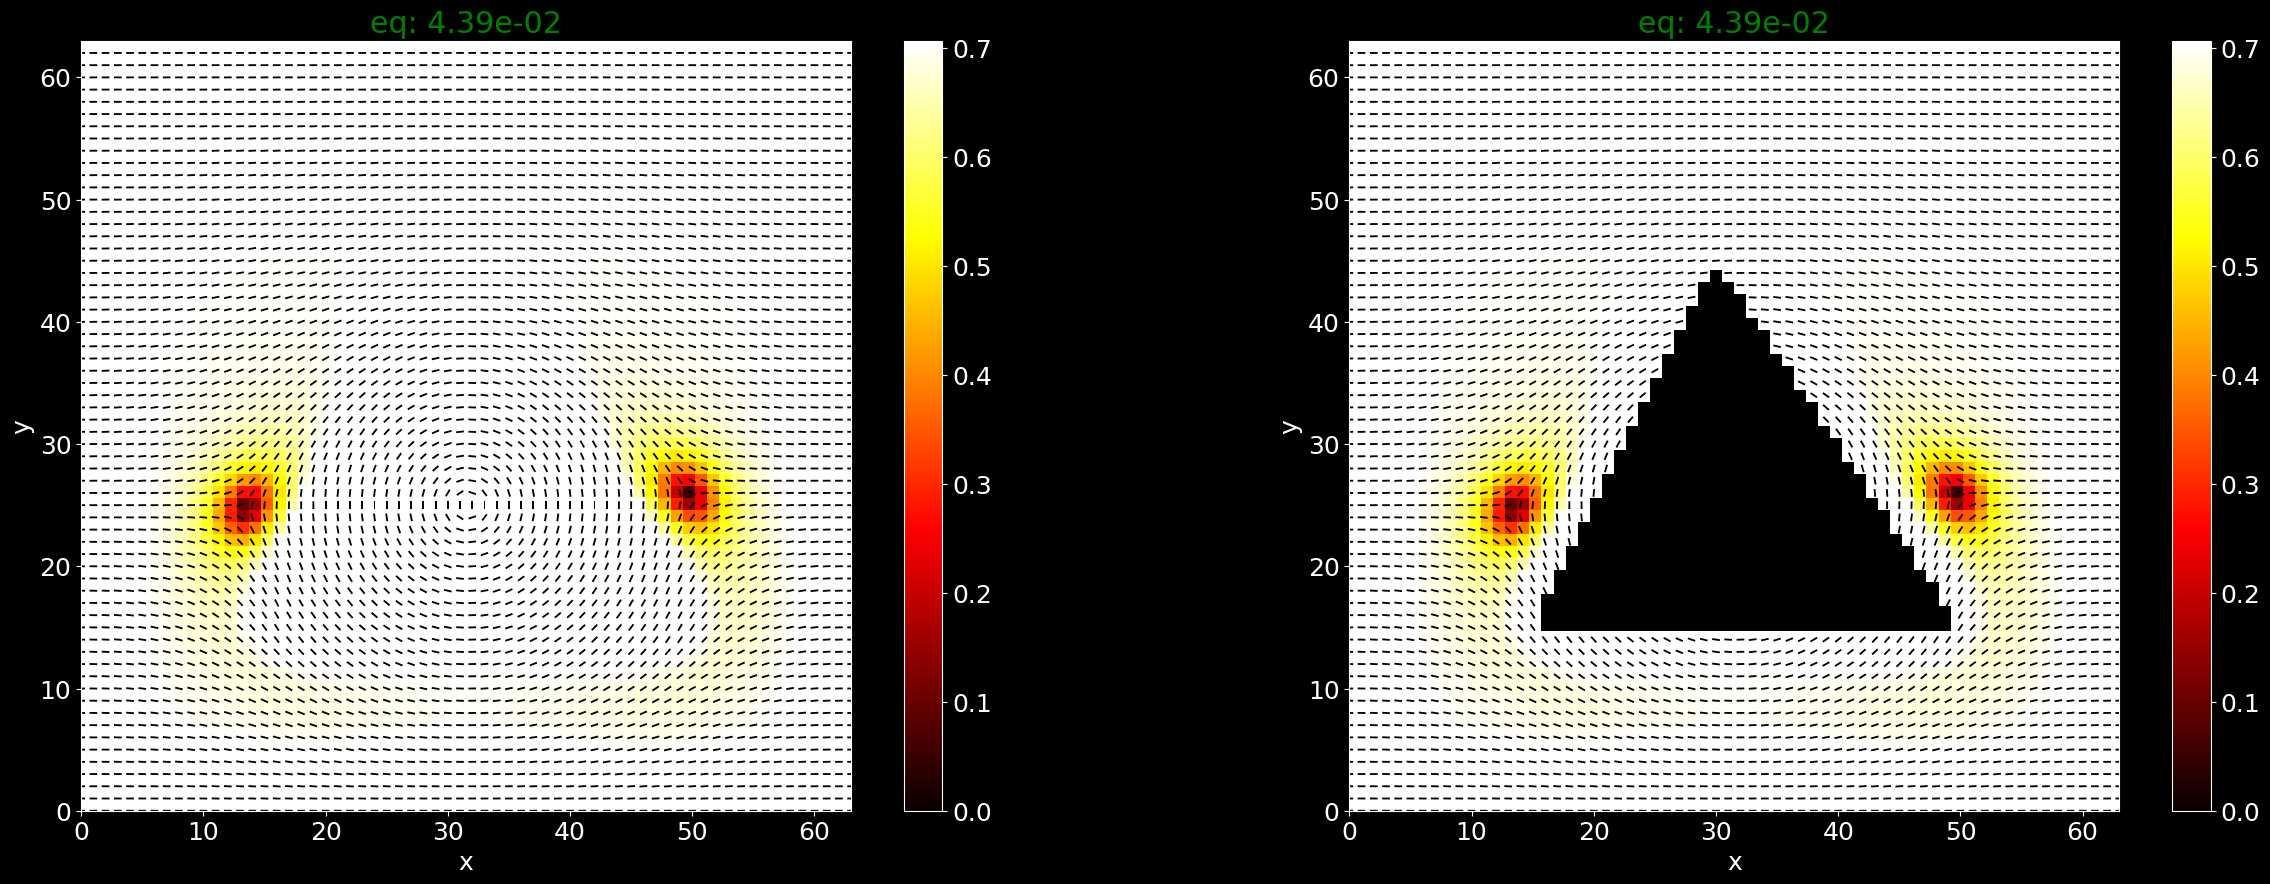

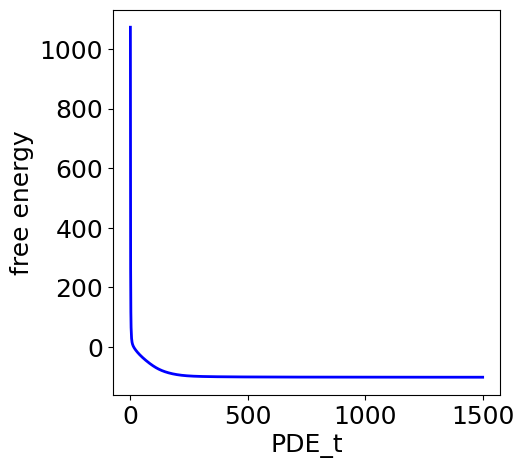

In [56]:

for seq_idx, seq in enumerate(seqs):

    # NOTE: We here only evaluate the sample at the final timestep and skip model_output as this is identical (since no noise is applied in last step).
    if seq_idx == 1:
        continue

    # remove frame dimension
    seq = torch.stack(seq, dim=0)
    if len(seq.shape) == 6:
        seq = seq.squeeze(-3)
        
    sel_samples = np.arange(no_samples)
    channels = np.arange(output_dim)
    N1 = 64
    N2 = 64
    for sel_sample in sel_samples:

        Azi0 = Mask_input[sel_sample,0,:,:].squeeze().squeeze()
        Azi = np.random.rand(N2, N1) * 2 * np.pi 
        mask = Mask_input[sel_sample,1,:,:].squeeze().squeeze()
        Azi[mask==0] = Azi0[mask==0]

        Q, f = relaxationBC_inclusion(N1, N2, Azi, 1500, mask, sel_sample, output_save_dir_validation,
                ywalltop_anchoring=1,
                ywallbottom_anchoring=1, 
                xwallleft_anchoring=1,
                xwallright_anchoring=1, 
                create_gif=True)
        

        Qxx = Q[:,:,0]
        Qxy = Q[:,:,1]
        Seq = np.sqrt(2)/2
        Azi_Qxx = Seq * np.cos(2*Azi0)
        Azi_Qxy = Seq * np.sin(2*Azi0)
        Qxx = np.where(mask == 0, Azi_Qxx, Qxx)
        Qxy = np.where(mask == 0, Azi_Qxy, Qxy)


        nx = np.zeros((N2,N1))
        ny = np.zeros((N2,N1))
        S = np.zeros((N2,N1))
        x, y = np.meshgrid(np.arange(0, N1, 1), np.arange(0, N2, 1))
        for i in range(N2):
            for j in range(N1):
                matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                                [Qxy[i, j], -Qxx[i, j]]])
                vals, vecs = np.linalg.eigh(matrix)
                index = np.argmax(vals)
                nx[i,j] = vecs[0, index]
                ny[i,j] = vecs[1, index]
                S[i,j] = vals[index]*2


        fig = plt.figure(figsize=(30, 10))
        ax = fig.add_subplot(1,2,1)
        im = ax.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
        plt.colorbar(im)
        plt.xlabel('x')
        plt.ylabel('y')
        ax.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
        if eval_residuals:
            title = f'eq: {residual[sel_sample]:.2e}'
            plt.title(title, color='green')
        filename = 'sample_' + str(sel_sample)  + '.png'
        S = np.where(mask != 0, S, np.nan)
        nx = np.where(mask != 0, nx, np.nan)
        ny = np.where(mask != 0, ny, np.nan)
        ax2 = fig.add_subplot(1,2,2)
        im = ax2.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
        plt.colorbar(im)
        plt.xlabel('x')
        plt.ylabel('y')
        ax2.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
        if eval_residuals:
            title = f'eq: {residual[sel_sample]:.2e}'
            plt.title(title, color='green')
        filename = 'relaxation_sample_' + str(sel_sample)  + '.png'
        plt.savefig(output_save_dir_validation + filename, bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close(fig)
        fig, ax = plt.subplots(figsize=(5, 5))
        fig.set_facecolor('white')
        ax.set_facecolor('white')
        ax.tick_params(colors='black')
        ax.spines['top'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.plot(f, color='blue',lw=2)
        plt.xlabel('PDE_t', color='black')
        plt.ylabel('free energy', color='black')
        filename ='relaxation_sample_free_energy_' + str(sel_sample)  + '.png'
        plt.savefig(output_save_dir_validation + filename, bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close(fig)
        os.makedirs(output_save_dir_validation + f'/relaxation_sample_{sel_sample}/', exist_ok=True)
        np.savetxt(output_save_dir_validation + f'/relaxation_sample_{sel_sample}/' + str(sel_channel) + '_free_energy.csv', f, delimiter=',')
        for sel_channel in channels:
            np.savetxt(output_save_dir_validation + f'/relaxation_sample_{sel_sample}/' + '_' + str(sel_channel) + '.csv', last_pred[sel_channel], delimiter=',')


        # create_gif = False


if eval_residuals:
    residuals_array = residual.detach().cpu().numpy()

    df_data = {'Sample Index': list(range(no_samples)),
            'Residuals (abs)': list(residuals_array)}
        
    df = pd.DataFrame(df_data)
    csv_path = os.path.join(output_save_dir_validation, 'sample_statistics.csv')
    df.to_csv(csv_path, index=False)

